In [2484]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel, DotProduct, RBF, Matern, RationalQuadratic

import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import adfuller

# so warnings dont clutter notebook
import warnings
warnings.filterwarnings('ignore')

In [2485]:
if os.path.isdir('Figures/'):
    path = './Figures/'
else:
    path = './'

- Consider data points $(x_t, y_t)$ for $t \in {1...n}$. 
- Forst describe the retalyionshiop between $x$ and $y$, then use this to predict $y^*$ gievn unseen $x^*$.
- In this case we will consider uni-variate time-series, where $x$ is composed of the past $k$ timesteps $x_{t-k} \to x_t$.

In [2486]:
# Define the time variable t
n_samples = 100
t = np.arange(n_samples)
data = pd.DataFrame({'t': t})

# Curate the fluctuating variable over the time-series (i.e. return)
asset = 'ETH/USD'
pair = asset.replace('/', '-')
df = pd.read_csv(f'../Datasets/Data/data_{pair}.csv')

closing = df.Close

# convert time data into datetime object, and extract closing prices
df.Time = pd.to_datetime(df.Time)
df.set_index(df.Time, inplace=True)
prices = df.Close

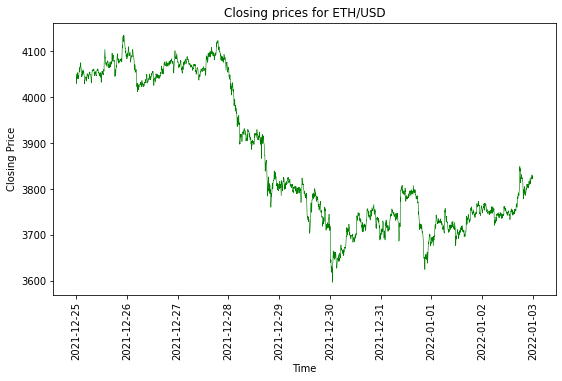

In [2487]:
# Plot of all closing prices for asset
fig = plt.figure(figsize=(9, 5))
plt.plot(prices, color='green', linewidth=0.6)
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title(f'Closing prices for {asset}')
plt.xticks(rotation=90)
plt.savefig(path + 'closing-prices-global.png')
plt.show()

In [2488]:
# Closing prices statistics
closing.describe()

count    2592.000000
mean     3868.862114
std       154.434284
min      3597.300000
25%      3738.575000
50%      3801.050000
75%      4051.100000
max      4135.400000
Name: Close, dtype: float64

In [2489]:
log_returns = np.log(closing) - np.log(closing.shift(1))
log_returns.dropna(inplace=True)
log_returns = np.array(log_returns)
abs_returns = np.abs(np.array(log_returns))

returns_pos = np.array(log_returns[log_returns >= 0])
returns_neg = np.abs(np.array(log_returns[log_returns < 0]))

print(f"max no. absolute returns in dataset: {abs_returns.shape[0]}")

np.random.seed(22)
rand_index = np.random.randint(0, abs_returns.shape[0] - n_samples)

data['y'] = abs_returns[rand_index: rand_index + n_samples]
data['y_signed'] = log_returns[rand_index: rand_index + n_samples]

data.head()

max no. absolute returns in dataset: 2591


,t,y,y_signed
0,0,0.001131,0.001131
1,1,0.000592,0.000592
2,2,0.000431,-0.000431
3,3,0.000943,-0.000943
4,4,0.002341,0.002341


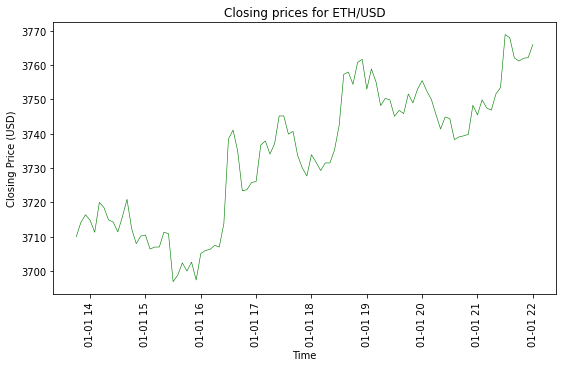

In [2490]:
# Plot of selected closing prices for asset
fig = plt.figure(figsize=(9, 5))
plt.plot(prices[rand_index: rand_index + n_samples], color='green', linewidth=0.6)
plt.xlabel('Time')
plt.ylabel('Closing Price (USD)')
plt.title(f'Closing prices for {asset}')
plt.xticks(rotation=90)
plt.savefig(path + 'closing-prices-local.png')
plt.show()

In [2491]:
# Use the Augmented Dickey-Fuller test to check whether original dataset (closing prices) is stationary
result_close = adfuller(np.array(closing))
p = result_close[1]

print('Closing prices stationarity:')
print(f'\tp-value: {p}')

if p <= 0.05:
	print("\t-> Null hypothesis rejected")
else:
	print("\t-> Null hypothesis cannot be rejected")

Closing prices stationarity:
	p-value: 0.5939162429250302
	-> Null hypothesis cannot be rejected


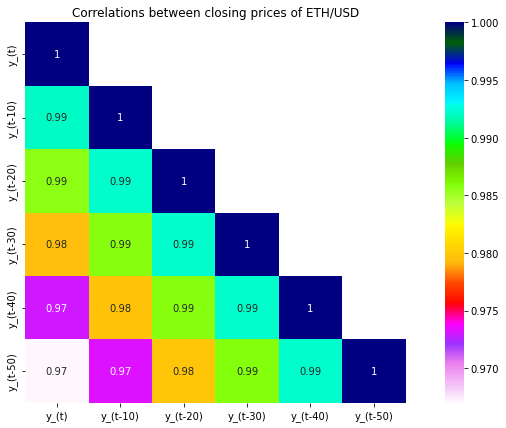

In [2492]:
# Evaluate correlations between variables in prices dataset
# construct shifted dataset of closing values
y_t = pd.Series(np.array(closing))
close_df = pd.DataFrame(y_t, columns=['y_(t)'])

for i in range(10, 60, 10):
    close_df[f'y_(t-{i})'] = y_t.shift(i)

close_df = close_df.dropna()

# compute the correlation of closing values and closing values shifted back through time-series
corr_matrix_close = close_df.corr()

# define a mask that hides the values in the upper triangular matrix
mask = np.triu(np.ones_like(corr_matrix_close, dtype=bool), k=1)

# genrate heatmap that uses this mask and map
fig = plt.figure(figsize=(14, 7))
sns.heatmap(corr_matrix_close, mask=mask, cmap=plt.cm.gist_ncar_r, square=True, annot=True)
plt.title(f"Correlations between closing prices of {asset}")
plt.savefig(path + 'correlations-prices.png')
plt.show()

In [2493]:
# positive and negative returns
data['y_+'] = data['y_signed'][data['y_signed'] >= 0]
data['y_-'] = np.abs(data['y_signed'][data['y_signed'] < 0])
data['y_+'] = data['y_+']
data['y_-'] = data['y_-']

data.head()

,t,y,y_signed,y_+,y_-
0,0,0.001131,0.001131,0.001131,NaN
1,1,0.000592,0.000592,0.000592,NaN
2,2,0.000431,-0.000431,NaN,0.000431
3,3,0.000943,-0.000943,NaN,0.000943
4,4,0.002341,0.002341,0.002341,NaN


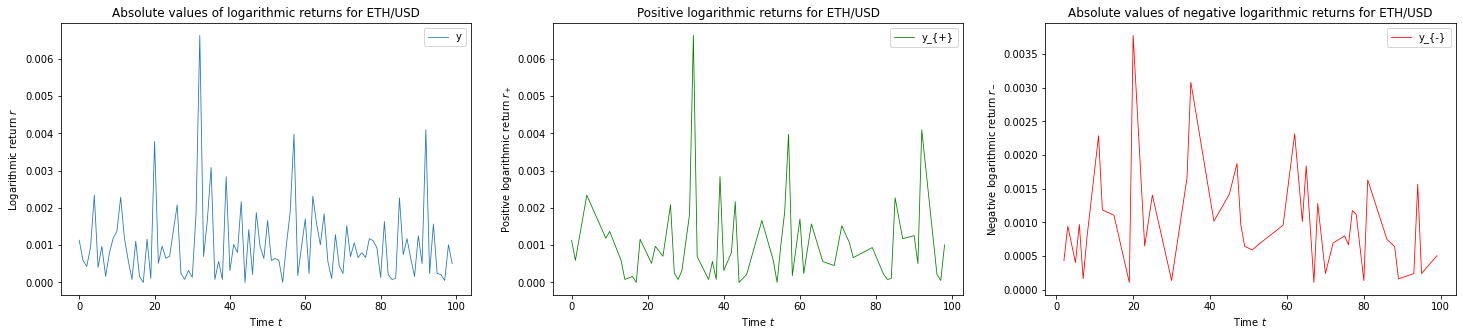

In [2494]:
# Plot of absolute log returns, positive returns, and absolute values of negatve returns
fig, ax = plt.subplots(1, 3, figsize=(25, 5))

sns.lineplot(x='t', y='y', data=data, label=r'y', ax=ax[0], linewidth=0.8) 
ax[0].set(title=f'Absolute values of logarithmic returns for {asset}', xlabel=r'Time $t$', ylabel=r'Logarithmic return $r$')
ax[0].legend()

sns.lineplot(x='t', y='y_+', data=data, label=r'y_{+}', ax=ax[1], linewidth=0.8, color='g') 
ax[1].set(title=f'Positive logarithmic returns for {asset}', xlabel=r'Time $t$', ylabel=r'Positive logarithmic return $r_{+}$')
ax[1].legend()

sns.lineplot(x='t', y='y_-', data=data, label=r'y_{-}', ax=ax[2], linewidth=0.8, color='r') 
ax[2].set(title=f'Absolute values of negative logarithmic returns for {asset}', xlabel=r'Time $t$', ylabel=r'Negative logarithmic return $r_{-}$')
ax[2].legend()

plt.savefig(path + 'logarithmic-returns.png')
plt.show()

In [2495]:
# Use the augmented dickey-fuller test to establish whether de-trended dataset (log returns) is stationary
result_rets = adfuller(np.array(data['y_signed']))
p = result_rets[1]

print('Log returns stationarity:')
print(f'\tp-value: {p}')

if p <= 0.05:
	print("\t-> Null hypothesis rejected")
else:
	print("\t-> Null hypothesis cannot be rejected")

Log returns stationarity:
	p-value: 8.305550668242478e-13
	-> Null hypothesis rejected


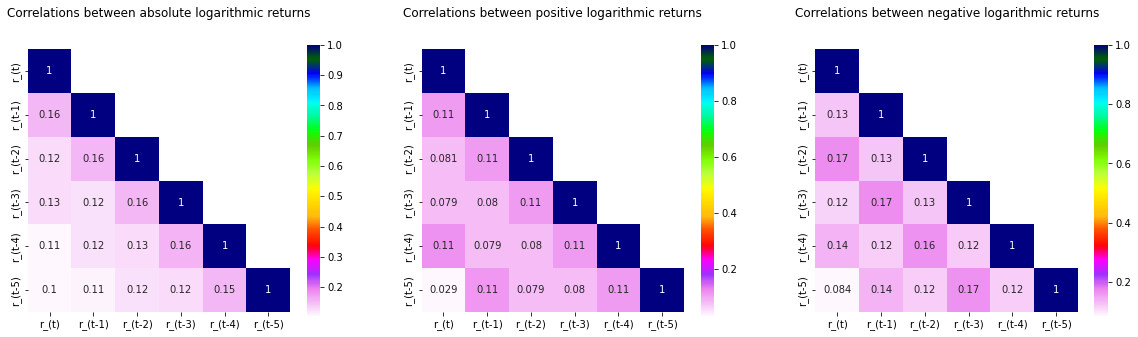

In [2496]:
# Evaluate correlations between variables in logarithmic returns dataset
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# construct shifted dataset of closing values
rets_t = pd.Series(np.array(abs_returns))
rets_df = pd.DataFrame(rets_t, columns=['r_(t)'])

for i in range(1, 6, 1):
    rets_df[f'r_(t-{i})'] = rets_t.shift(i)

rets_df = rets_df.dropna()

# compute the correlation of absolute returns and shifted values back through time-series
corr_matrix_rets = rets_df.corr()

# define a mask that hides the values in the upper triangular matrix
mask_1 = np.triu(np.ones_like(corr_matrix_rets, dtype=bool), k=1)

# genrate heatmap that uses this mask and map
sns.heatmap(corr_matrix_rets, mask=mask_1, cmap=plt.cm.gist_ncar_r, square=True, annot=True, ax=ax[0])
ax[0].set_title("Correlations between absolute logarithmic returns", y=1.1)

# Repeat for positive returns
rpos_t = pd.Series(np.array(returns_pos))
rpos_df = pd.DataFrame(rpos_t, columns=['r_(t)'])

for i in range(1, 6, 1):
    rpos_df[f'r_(t-{i})'] = rpos_t.shift(i)

rpos_df = rpos_df.dropna()

corr_matrix_rpos = rpos_df.corr()
mask_2 = np.triu(np.ones_like(corr_matrix_rpos, dtype=bool), k=1)

sns.heatmap(corr_matrix_rpos, mask=mask_2, cmap=plt.cm.gist_ncar_r, square=True, annot=True, ax=ax[1])
ax[1].set_title("Correlations between positive logarithmic returns", y=1.1)

# Repeat for negative returns
rneg_t = pd.Series(np.array(returns_neg))
rneg_df = pd.DataFrame(rneg_t, columns=['r_(t)'])

for i in range(1, 6, 1):
    rneg_df[f'r_(t-{i})'] = rneg_t.shift(i)

rneg_df = rneg_df.dropna()

corr_matrix_rneg = rneg_df.corr()
mask_3 = np.triu(np.ones_like(corr_matrix_rneg, dtype=bool), k=1)

sns.heatmap(corr_matrix_rneg, mask=mask_3, cmap=plt.cm.gist_ncar_r, square=True, annot=True, ax=ax[2])
ax[2].set_title("Correlations between negative logarithmic returns", y=1.1)

plt.savefig(path + 'correlations-returns.png')
plt.show()

In [2497]:
# split data into training and testing sets
# X = times; y = return
X = data['t'].values.reshape(n_samples, 1)
y = data['y'].values.reshape(n_samples, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

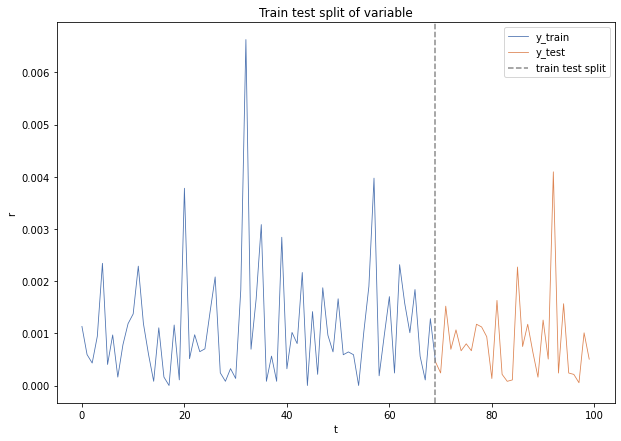

In [2498]:
# plot the split datasets
fig, ax = plt.subplots(figsize=(10, 7))

X_test_extended = np.append(X_train[-1], X_test.flatten())
y_test_extended = np.append(y_train[-1], y_test.flatten())

sns.lineplot(x=X_train.flatten(), y=y_train.flatten(), color=sns.color_palette(palette='deep')[0], ax=ax, linewidth=0.8, label='y_train') 
sns.lineplot(x=X_test_extended, y=y_test_extended, color=sns.color_palette(palette='deep')[1], ax=ax, linewidth=0.8, label='y_test') 

ax.axvline(x=X_train.flatten()[-1], color=sns.color_palette(palette='deep')[7], linestyle='--', label='train test split')

ax.legend()
ax.set(title='Train test split of variable', xlabel='t', ylabel='r')

plt.savefig(path + 'correlations-prices.png')
plt.show()

In [2499]:
# define the kernel of the gaussian process model

# WhiteKernel models the noise of the signal as iid
# 1 hyperparameter `noise_level`
whitekernel = WhiteKernel(noise_level=1, noise_level_bounds=(1e-3, 1e3))

# ConstantKernel scales the magnitude of the kernel by modifying the mean of the Gaussian process
# 1 hyperparam `constant_value`
constantkernel = ConstantKernel(constant_value=1, constant_value_bounds=(1e-5, 1e5))

# ESSKernel allows the modelling of repeating functions
# 2 hyperparams `length_scale` and `periodicity`
esskernel =  ExpSineSquared(length_scale=1e-3, length_scale_bounds=(1e-8, 1e2), periodicity=60, periodicity_bounds=(40, 80))

# sum/product kernel
kernel = whitekernel + constantkernel * esskernel

Gaussian Process model hhyperparameters:
- `alpha` = variance of iid noise added to labels
- `normalise_y` = constant mean function used (False => zero mean; True => mean of training data)
- `n_restarts_optimizer` = number of different initialisations to try during tuning
- `optimiser` = default is given

In [2500]:
# specify Gaussian model hyperparameters
alpha = 0.0
normalise_y = True
n_restarts_optimiser = 10
optimiser = 'fmin_l_bfgs_b'

# initialise the gaussian process regression model
gp = GaussianProcessRegressor(
    kernel=kernel,
    optimizer=optimiser,
    n_restarts_optimizer=n_restarts_optimiser,
    normalize_y=normalise_y,
    alpha=alpha
)

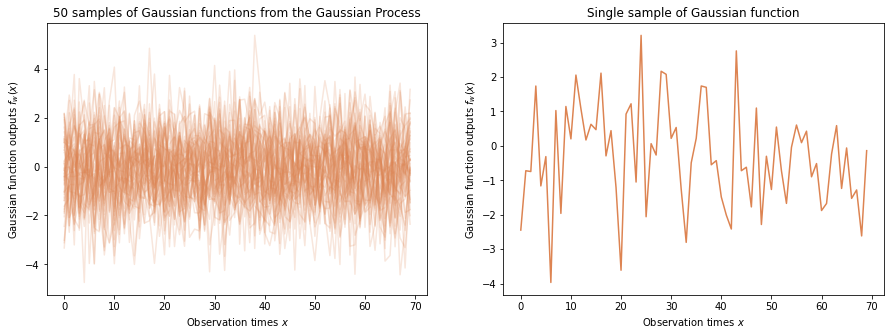

In [2501]:
# sample from prior distribution
n_samples = 50
x_plot = X_train[..., 0].copy()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

prior_samples = gp.sample_y(X=X_train, n_samples=n_samples)
single_sample = gp.sample_y(X=X_train, n_samples=1).squeeze(1)

for i in range(n_samples):
    sns.lineplot(x=x_plot, y=prior_samples[:, i], color=sns.color_palette(palette='deep')[1], alpha=0.2, ax=ax[0])

ax[0].set(title='50 samples of Gaussian functions from the Gaussian Process', xlabel=r'Observation times $x$', ylabel=r'Gaussian function outputs $f_w(x)$')

sns.lineplot(x=x_plot, y=single_sample, color=sns.color_palette(palette='deep')[1], ax=ax[1])
ax[1].set(title='Single sample of Gaussian function', xlabel=r'Observation times $x$', ylabel=r'Gaussian function outputs $f_w(x)$')

plt.savefig(path + 'gp-prior-distribution.png')
plt.show()

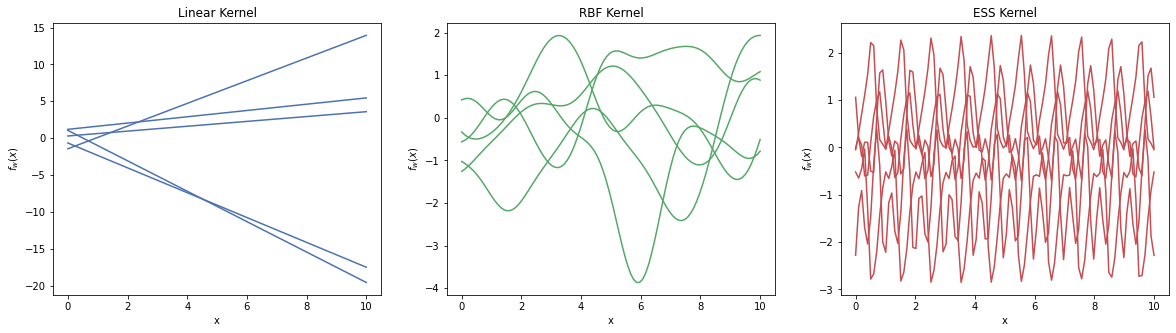

In [2502]:
# Linear kernel
gp_linear = GaussianProcessRegressor(
    kernel=DotProduct()
)

# RBF kernel
gp_rbf = GaussianProcessRegressor(
    kernel=RBF()
)

# Exponential Sine Squared kernel
gp_ess = GaussianProcessRegressor(
    kernel=ExpSineSquared()
)

# plot a variety of random kernel functions from each type of kernel
n_samples = 5
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

x_plot = np.linspace(0, 10, 100)
x_space = x_plot.reshape(x_plot.shape[0], 1)

prior_samples_linear = gp_linear.sample_y(X=x_space, n_samples=n_samples)
prior_samples_rbf = gp_rbf.sample_y(X=x_space, n_samples=n_samples)
prior_samples_ess = gp_ess.sample_y(X=x_space, n_samples=n_samples)

for i in range(n_samples):
    sns.lineplot(x=x_plot, y=prior_samples_linear[:, i], color=sns.color_palette(palette='deep')[0], ax=ax[0])
ax[0].set(title='Linear Kernel', xlabel=r'x', ylabel=r'$f_w(x)$')

for i in range(n_samples):
    sns.lineplot(x=x_plot, y=prior_samples_rbf[:, i], color=sns.color_palette(palette='deep')[2], ax=ax[1])
ax[1].set(title='RBF Kernel', xlabel=r'x', ylabel=r'$f_w(x)$')

for i in range(n_samples):
    sns.lineplot(x=x_plot, y=prior_samples_ess[:, i], color=sns.color_palette(palette='deep')[3], ax=ax[2])
ax[2].set(title='ESS Kernel', xlabel=r'x', ylabel=r'$f_w(x)$')

plt.savefig(path + 'varying-kernels.png')
plt.show()

In [2503]:
# tune model hyperparameters through MLE
gp.fit(X_train, y_train)
print("Optimised kernel params: \n", pd.Series(gp.kernel_.get_params()))

Optimised kernel params: 
 k1                                                  WhiteKernel(noise_level=0.496)
k2                               0.738**2 * ExpSineSquared(length_scale=0.001, ...
k1__noise_level                                                           0.495952
k1__noise_level_bounds                                             (0.001, 1000.0)
k2__k1                                                                    0.738**2
k2__k2                           ExpSineSquared(length_scale=0.001, periodicity...
k2__k1__constant_value                                                    0.544278
k2__k1__constant_value_bounds                                    (1e-05, 100000.0)
k2__k2__length_scale                                                         0.001
k2__k2__periodicity                                                      60.001786
k2__k2__length_scale_bounds                                         (1e-08, 100.0)
k2__k2__periodicity_bounds                                  

In [2504]:
# make predictions over entire dataset, returning the predicted instances and covariance
y_pred, y_cov = gp.predict(X, return_cov=True)

# compute the predictions standard deviation (from which we can get the confidence interval)
y_std = np.sqrt(y_cov.diagonal())

# store prediction data
data['y_pred'] = y_pred
data['y_std'] = y_std
data['pred_upper_bound'] = data['y_pred'] + 2 * data['y_std']
data['pred_lower_bound'] = data['y_pred'] - 2 * data['y_std']

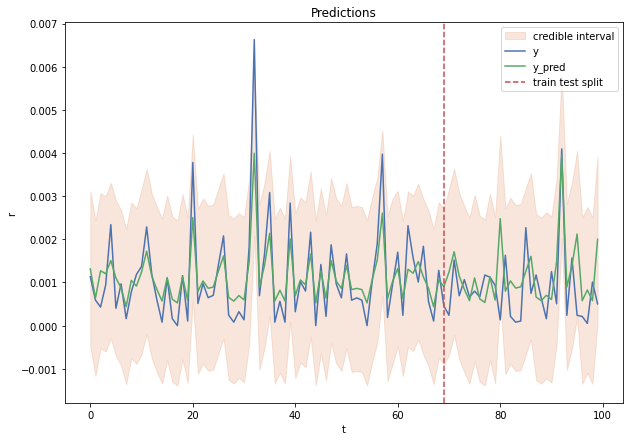

In [2505]:
# plot the predictions
fig, ax = plt.subplots(figsize=(10, 7))

ax.fill_between(
    x=data['t'],
    y1=data['pred_upper_bound'],
    y2=data['pred_lower_bound'],
    color=sns.color_palette(palette='deep')[1],
    alpha=0.2,
    label='confidence interval'
)

sns.lineplot(x='t', y='y', data=data, color=sns.color_palette(palette='deep')[0], ax=ax, label='y')
sns.lineplot(x='t', y='y_pred', data=data, color=sns.color_palette(palette='deep')[2], ax=ax, label='y_pred')

ax.axvline(X_train.shape[0] - 1, color=sns.color_palette(palette='deep')[3], linestyle='--', label='train test split')
ax.legend()
ax.set(title='Predictions', xlabel='t', ylabel='r')

plt.savefig(path + 'gp-training-predictions.png')
plt.show()

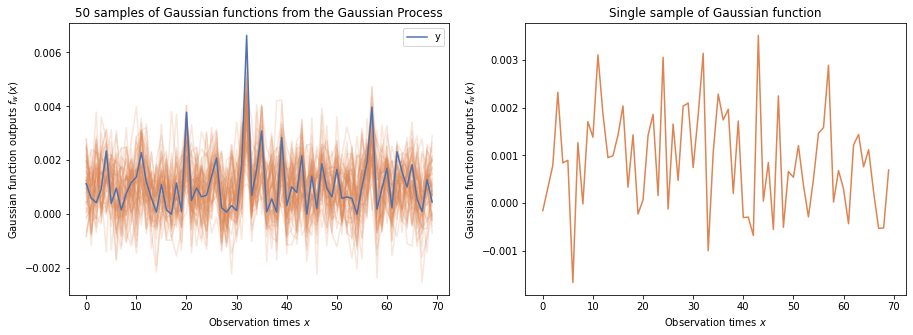

In [2520]:
# sample from posterior distribution
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
n_samples = 50
post_samples = gp.sample_y(X=X_train, n_samples=n_samples).squeeze(1)
single_post_sample = gp.sample_y(X=X_train, n_samples=1).squeeze(1).squeeze(1)
x_plot = X_train[..., 0].copy()

for i in range(n_samples):
    sns.lineplot(x=x_plot, y=post_samples[:, i], color=sns.color_palette(palette='deep')[1], alpha=0.2, ax=ax[0])

sns.lineplot(x=x_plot, y=y_train[:, 0], color=sns.color_palette(palette='deep')[0], ax=ax[0], label='y')

ax[0].set(title='50 samples of Gaussian functions from the Gaussian Process', xlabel=r'Observation times $x$', ylabel=r'Gaussian function outputs $f_w(x)$')
ax[0].legend()

sns.lineplot(x=x_plot, y=single_post_sample, color=sns.color_palette(palette='deep')[1], ax=ax[1])
ax[1].set(title='Single sample of Gaussian function', xlabel=r'Observation times $x$', ylabel=r'Gaussian function outputs $f_w(x)$')

plt.savefig(path + 'gp-posterior-distribution.png')
plt.show()

In [ ]:
# evaluating the error in our model
y_pred_train = gp.predict(X_train)
y_pred_test = gp.predict(X_test)

# calculate MSE of predictions and test labels
err_train = y_pred_train - y_train
err_test = y_pred_test - y_test
MSE_train = np.mean(np.power(err_train, 2))
MSE_test = np.mean(np.power(err_test, 2))

print(f"MSE Train = {MSE_train}")
print(f"MSE Test = {MSE_test}")
print(f"MSE relative increase = {(MSE_test / MSE_train)}")

MSE Train = 3.153353583894182e-07
MSE Test = 6.97017695622508e-07
MSE relative increase = 2.210401330134813


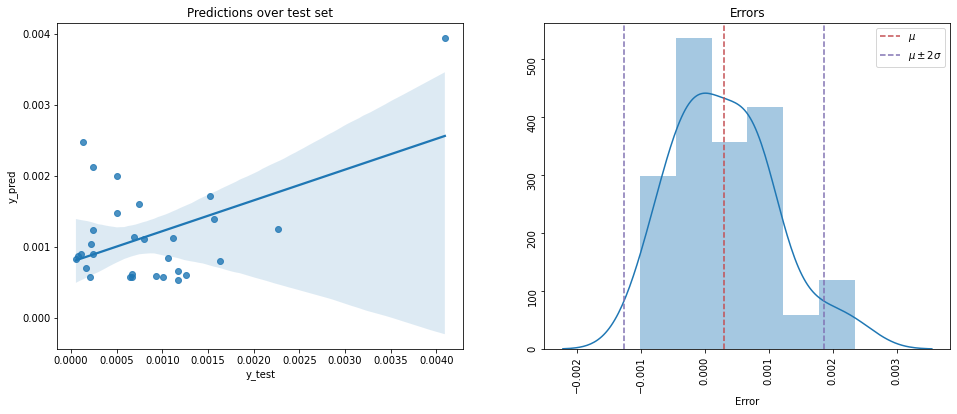

In [ ]:
# error plots
err_test_mean = np.mean(err_test.flatten())
err_test_std = np.std(err_test.flatten())

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.regplot(x=y_test.flatten(), y=y_pred_test.flatten(), ax=ax[0])
ax[0].set(title='Predictions over test set', xlabel='y_test', ylabel='y_pred')

sns.distplot(a=err_test.flatten(), ax=ax[1])

ax[1].axvline(x=err_test_mean, color=sns.color_palette(palette='deep')[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=(err_test_mean + 2 * err_test_std), color=sns.color_palette(palette='deep')[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=(err_test_mean - 2 * err_test_std), color=sns.color_palette(palette='deep')[4], linestyle='--')

ax[1].set(title='Errors', xlabel='Error', ylabel='')
ax[1].tick_params(labelrotation=90)
ax[1].legend()

plt.savefig(path + 'gp-prediction-errors.png')
plt.show()